# GLM with small dataset
idea:

use generalized linear model to predict gap days as a function of drug, using total drug duration as an offset \
drug: factor with 16 levels

## data

In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import glm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
df = pd.read_csv("../../dataset/small_focused_df.csv")
df = df.drop(columns=["eid"])
df.head()

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code
0,708298,1700807090784,12/12/2013,10/01/2014,1,0,midazolam,N05CD08
1,708298,1666447356341,29/04/2013,28/05/2013,1,0,midazolam,N05CD08
2,708298,1194000953715,05/09/2013,26/10/2013,4,0,midazolam,N05CD08
3,708298,1065151983292,16/02/2011,17/03/2011,1,0,midazolam,N05CD08
4,708298,996432425515,14/03/2016,12/04/2016,1,0,midazolam,N05CD08


In [7]:
print(len(df["atc_code"].unique()))
print(len(df))

16
17668


In [158]:
df["drug_era_start_date"] = pd.to_datetime(df["drug_era_start_date"], format="%d/%m/%Y")
df["drug_era_end_date"] = pd.to_datetime(df["drug_era_end_date"], format="%d/%m/%Y")
# duration = drug_era_end_date - drug_era_start_date + 1
df["duration"] = (df["drug_era_end_date"] - df["drug_era_start_date"]).dt.days + 1

In [159]:
df.head()

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration
0,708298,1700807090784,2013-12-12,2014-01-10,1,0,midazolam,N05CD08,30
1,708298,1666447356341,2013-04-29,2013-05-28,1,0,midazolam,N05CD08,30
2,708298,1194000953715,2013-09-05,2013-10-26,4,0,midazolam,N05CD08,52
3,708298,1065151983292,2011-02-16,2011-03-17,1,0,midazolam,N05CD08,30
4,708298,996432425515,2016-03-14,2016-04-12,1,0,midazolam,N05CD08,30


In [27]:
# print all the drug_concept_id
print(df["drug_concept_id"].unique())

[  708298   710650   733523   902722   929435   967496   978236  1377141
  1436650  1583722  1742253  1778162 19005147 19095043 19122137 40239216]


In [31]:
# see the summary statistics of duration for drugs
print(df[df["drug_concept_id"] == 733523]["duration"].describe())

count     441.000000
mean      254.829932
std       340.149433
min         5.000000
25%        32.000000
50%       116.000000
75%       312.000000
max      2277.000000
Name: duration, dtype: float64


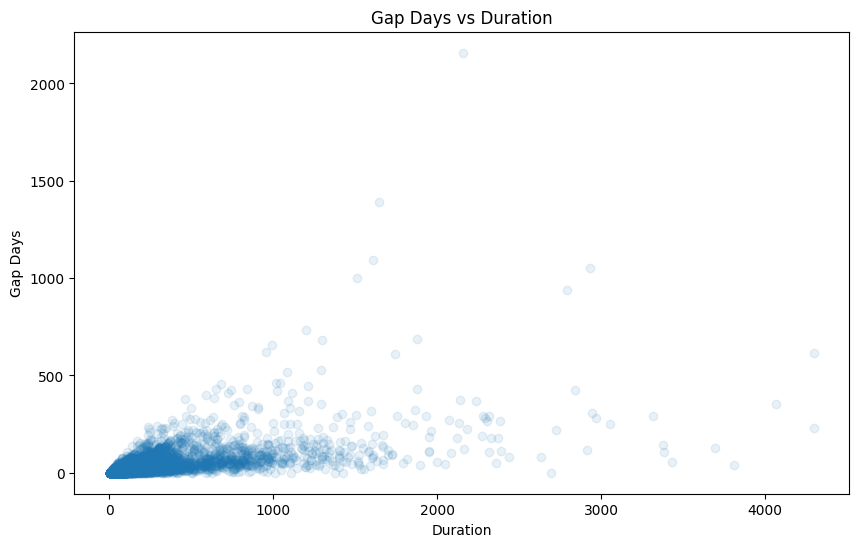

Correlation between duration and gap_days: 0.645


In [148]:
plt.figure(figsize=(10, 6))
plt.scatter(df["duration"], df["gap_days"], alpha=0.1)
plt.xlabel("Duration")
plt.ylabel("Gap Days")
plt.title("Gap Days vs Duration")
plt.show()

# Print correlation
print(
    f"Correlation between duration and gap_days: {df['duration'].corr(df['gap_days']):.3f}"
)

## GLM

log(E(gap_days)) = β₀ + β₁X₁ + β₂X₂ + ... + log(duration), which is equivalent to \
E(gap_days) = duration × exp(β₀ + β₁X₁ + β₂X₂ + ...)

log(λᵢ) = β₀ + β₁X₁ᵢ + β₂X₂ᵢ + ... + log(durationᵢ)

Where: \
E(gap_days) is the expected number of gap days \
β₀ is the intercept \
β₁, β₂, ... are coefficients for each drug type \
X₁, X₂, ... are dummy variables (0/1) for drug types

In [62]:
# Fit GLM with Poisson distribution
poisson_model = glm(
    formula="gap_days ~ C(atc_code)",
    data=df,
    family=sm.families.Poisson(link=sm.families.links.Log()),
    offset=np.log(df["duration"]),
)
poisson_results = poisson_model.fit()
# Display summary
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               gap_days   No. Observations:                17668
Model:                            GLM   Df Residuals:                    17652
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2294e+05
Date:                Fri, 22 Nov 2024   Deviance:                   2.2328e+05
Time:                        00:45:38   Pearson chi2:                 2.39e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.8248
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

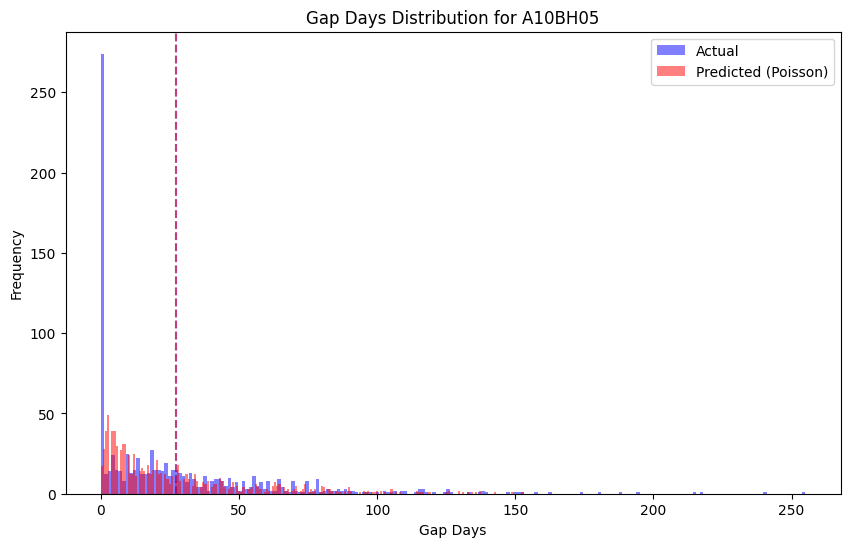

Actual mean: 27.27
Predicted mean: 27.27
Actual variance: 1255.70
Predicted variance: 27.27


In [39]:
# Filter data for N05CD08
drug_data = df[df["atc_code"] == "A10BH05"].copy()

# Get actual gap days
actual_gap_days = drug_data["gap_days"]

# Calculate predicted gap days (λ)
# Assuming your model results are in 'results'
drug_coef = poisson_results.params[
    poisson_results.params.index == "C(atc_code)[T.A10BH05]"
].values[0]
predicted_means = drug_data["duration"] * np.exp(
    poisson_results.params["Intercept"] + drug_coef
)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(actual_gap_days, bins=200, alpha=0.5, label="Actual", color="blue")
plt.hist(
    np.random.poisson(predicted_means),
    bins=200,
    alpha=0.5,
    label="Predicted (Poisson)",
    color="red",
)

plt.title("Gap Days Distribution for A10BH05")
plt.xlabel("Gap Days")
plt.ylabel("Frequency")
plt.legend()

# Optional: Add vertical lines for means
plt.axvline(actual_gap_days.mean(), color="blue", linestyle="--", alpha=0.5)
plt.axvline(predicted_means.mean(), color="red", linestyle="--", alpha=0.5)

plt.show()

# Print some summary statistics
print(f"Actual mean: {actual_gap_days.mean():.2f}")
print(f"Predicted mean: {predicted_means.mean():.2f}")
print(f"Actual variance: {actual_gap_days.var():.2f}")
print(
    f"Predicted variance: {predicted_means.mean():.2f}"
)  # For Poisson, mean = variance

In [63]:
# Fit GLM with Negative Binomial distribution
nb_model = glm(
    formula="gap_days ~ C(atc_code)",
    data=df,
    family=sm.families.NegativeBinomial(alpha=1.0),
    offset=np.log(df["duration"]),
)
nb_results = nb_model.fit()
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               gap_days   No. Observations:                17668
Model:                            GLM   Df Residuals:                    17652
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35304.
Date:                Fri, 22 Nov 2024   Deviance:                       32591.
Time:                        00:46:58   Pearson chi2:                 4.94e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2433
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [145]:
# Compare predicted vs actual variance
def compare_variance(model_results, data):
    predicted = model_results.predict(data)
    actual_var = data["gap_days"].var()
    predicted_var = predicted.var()

    print(f"Actual variance: {actual_var:.2f}")
    print(f"Predicted variance: {predicted_var:.2f}")
    print(f"Ratio (actual/predicted): {actual_var/predicted_var:.2f}")


print("Poisson Model:")
compare_variance(poisson_results, df)
print("\nNegative Binomial Model:")
compare_variance(nb_results, df)

Poisson Model:
Actual variance: 1898.77
Predicted variance: 0.00
Ratio (actual/predicted): 580161.77

Negative Binomial Model:
Actual variance: 1898.77
Predicted variance: 0.00
Ratio (actual/predicted): 1199659.22


Model Comparison:
Poisson AIC: 245918.62757559735
Negative Binomial AIC: 70640.4274670641

Estimated alpha: 1.0

Diagnostics:
Log-likelihood: -35304.21373353205
Deviance: 32590.950900319076
Pearson Chi-squared: 49433.33060094344
Df Residuals: 17652

Dispersion (Pearson Chi2/df): 2.80


Text(0.5, 1.0, 'Gap Days Distribution for J01GB01, S01AA12')

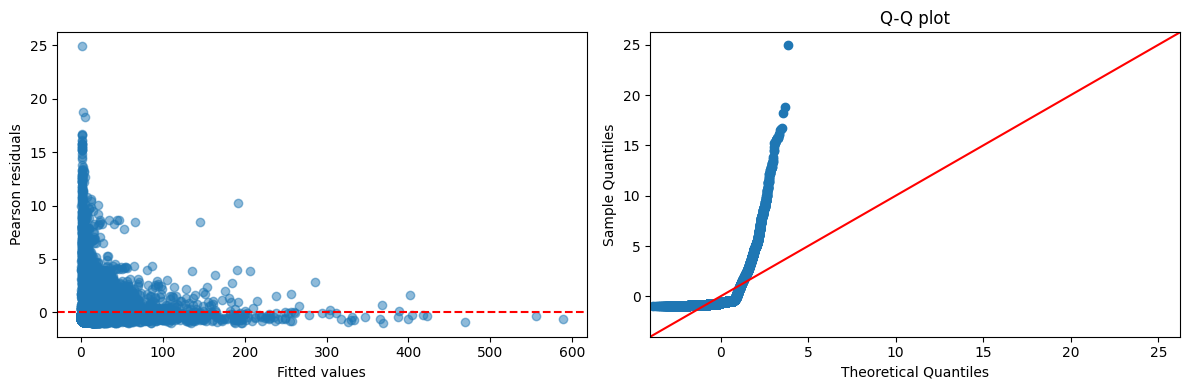

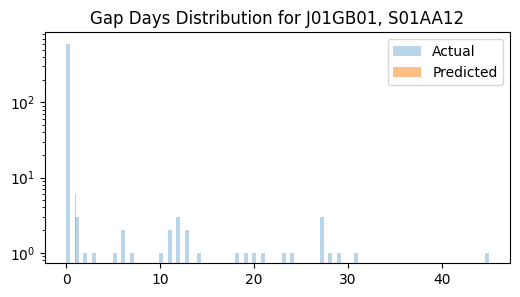

In [185]:
from statsmodels.graphics.gofplots import ProbPlot

# Print comparison
print("Model Comparison:")
print(f"Poisson AIC: {poisson_results.aic}")
print(f"Negative Binomial AIC: {nb_results.aic}")
print(f"\nEstimated alpha: {nb_results.scale}")

# Basic diagnostics
print("\nDiagnostics:")
print(f"Log-likelihood: {nb_results.llf}")
print(f"Deviance: {nb_results.deviance}")
print(f"Pearson Chi-squared: {nb_results.pearson_chi2}")
print(f"Df Residuals: {nb_results.df_resid}")

# Calculate and print dispersion (should be closer to 1 than Poisson)
dispersion = nb_results.pearson_chi2 / nb_results.df_resid
print(f"\nDispersion (Pearson Chi2/df): {dispersion:.2f}")

# Plot diagnostics
residuals = nb_results.resid_pearson
fitted = nb_results.fittedvalues

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# First subplot
ax1.scatter(fitted, residuals, alpha=0.5)
ax1.axhline(y=0, color="r", linestyle="--")
ax1.set_xlabel("Fitted values")
ax1.set_ylabel("Pearson residuals")

# Second subplot
ProbPlot(residuals).qqplot(ax=ax2, line="45")
ax2.set_title("Q-Q plot")

plt.tight_layout()

# Look at one drug's distribution
drug = df["atc_code"].unique()[3]
drug_data = df[df["atc_code"] == drug]

plt.figure(figsize=(6, 3))
plt.hist(drug_data["gap_days"], bins=100, alpha=0.3, label="Actual")
predicted_means = nb_results.predict(drug_data)
plt.hist(
    np.random.negative_binomial(
        n=1, p=1 / (1 + predicted_means), size=len(predicted_means)
    ),
    bins=30,
    alpha=0.5,
    label="Predicted",
)
# log scale
plt.yscale("log")
plt.legend()
plt.title(f"Gap Days Distribution for {drug}")

## analysis on the zeros

In [78]:
# 1. percentage of zeros for each drug
zero_by_drug = (
    df.groupby("atc_code")
    .agg({"gap_days": lambda x: (x == 0).mean() * 100})
    .rename(columns={"gap_days": "zero_percentage"})
)

print("Percentage of zero gap days by drug:")
print(zero_by_drug.sort_values("zero_percentage", ascending=False))

# 2. patients
if "eid" in df.columns:
    zero_by_patient = (
        df.groupby("eid")
        .agg({"gap_days": lambda x: (x == 0).mean() * 100})
        .rename(columns={"gap_days": "zero_percentage"})
    )

    print("\nPercentage of patients with all zeros:")
    print(f"{(zero_by_patient['zero_percentage'] == 100).mean() * 100:.2f}%")

# 3. statistics about zeros
print("\nOverall zero statistics:")
print(f"Total observations: {len(df)}")
print(f"Number of zeros: {(df['gap_days'] == 0).sum()}")
print(f"Percentage zeros: {(df['gap_days'] == 0).mean() * 100:.2f}%")

Percentage of zero gap days by drug:
                  zero_percentage
atc_code                         
J01AA03, S01AA02        96.897810
J01GB01, S01AA12        95.040000
N05CD08                 94.839192
J01DC02, S01AA27        93.649733
J01MA12, S01AE05        92.194745
S01EC01                 85.665334
N05AA02                 84.854369
L01XX79                 83.495146
S01GX05                 81.274025
L01XX05                 68.874773
N06BA07                 60.765125
L01BB02                 55.271565
A10BJ01                 45.688351
A10BH02                 40.878378
N06DA03                 32.879819
A10BH05                 27.771679

Percentage of patients with all zeros:
73.72%

Overall zero statistics:
Total observations: 17668
Number of zeros: 13249
Percentage zeros: 74.99%


In [79]:
# First identify patients with all zeros
zero_by_patient = (
    df.groupby("eid")
    .agg({"gap_days": lambda x: (x == 0).mean()})
    .rename(columns={"gap_days": "zero_percentage"})
)

# Get IDs of patients who have some non-zero gaps
patients_with_gaps = zero_by_patient[zero_by_patient["zero_percentage"] < 1.0].index

# Filter the dataframe to keep only these patients
df_filtered = df[df["eid"].isin(patients_with_gaps)].copy()

# Calculate percentage of zeros for each drug in filtered dataset
zero_by_drug_filtered = (
    df_filtered.groupby("atc_code")
    .agg({"gap_days": lambda x: (x == 0).mean() * 100})
    .rename(columns={"gap_days": "zero_percentage"})
)

print("Percentage of zero gap days by drug (after removing all-zero patients):")
print(zero_by_drug_filtered.sort_values("zero_percentage", ascending=False))

print("\nOverall zero statistics in filtered dataset:")
print(f"Total observations: {len(df_filtered)}")
print(f"Number of zeros: {(df_filtered['gap_days'] == 0).sum()}")
print(f"Percentage zeros: {(df_filtered['gap_days'] == 0).mean() * 100:.2f}%")

Percentage of zero gap days by drug (after removing all-zero patients):
                  zero_percentage
atc_code                         
L01XX79                 73.694391
J01DC02, S01AA27        68.227425
J01AA03, S01AA02        66.000000
S01GX05                 64.479167
J01MA12, S01AE05        63.799283
L01XX05                 63.626723
N05CD08                 59.883721
N06BA07                 56.975610
S01EC01                 54.774775
L01BB02                 51.640760
J01GB01, S01AA12        50.000000
N05AA02                 42.857143
A10BJ01                 40.953947
A10BH02                 38.917976
N06DA03                 25.063291
A10BH05                 15.964240

Overall zero statistics in filtered dataset:
Total observations: 9198
Number of zeros: 4779
Percentage zeros: 51.96%


## zero-inflated model

**Zero-Inflation Component (Logistic)** \
logit(π) = γ₀ + γ₁X₁ + γ₂X₂ + ... \
Where:\
π = probability of extra zero \
X₁, X₂, etc. = drug dummy variables\
γ's = zero-inflation model coefficients\
γ₀ is inflate_const \
To get probability: P(extra_zero) = exp(logit(π))/(1 + exp(logit(π)))

**Count Component (Negative Binomial)** \
log(μ) = β₀ + β₁X₁ + β₂X₂ + ... + log(duration) \
Where:\
μ = expected count (when not zero) \
X₁, X₂, etc. = drug dummy variables \
β's = count model coefficients\
β₀ is const

**Variance and mean** \
E(Y) = μ \
Var(Y) = μ + αμ² \
where α is the dispersion parameter

**Final Probability Model**: \
P(Y = 0) = π + (1-π)P(Y = 0|NB(μ,α)) \
P(Y = k) = (1-π)P(Y = k|NB(μ,α)) for k > 0

In [130]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

# Convert categorical variables to dummies and ensure numeric types
X = pd.get_dummies(df["atc_code"], prefix="drug").astype(float)
X = sm.add_constant(X)  # Add constant term
y = df["gap_days"].astype(float)
offset = np.log(df["duration"].astype(float))

# Fit ZINB model with careful optimization settings
zinb_model = ZeroInflatedNegativeBinomialP(
    y,  # gap_days (response)
    X,  # predictors for count model
    exog_infl=X,  # predictors for zero-inflation model
    offset=offset,
)

zinb_results = zinb_model.fit(
    method="bfgs",
    maxiter=100000,  # Increased iterations
    disp=True,
    gtol=1e-8,
    full_output=True,
)

print(zinb_results.summary())
print("\nModel Comparison:")
print(f"Regular NB AIC: {nb_results.aic}")
print(f"Zero-Inflated NB AIC: {zinb_results.aic}")

/Users/punny/Repos/Project_PerMed/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 1.542418
         Iterations: 216
         Function evaluations: 217
         Gradient evaluations: 217
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                          gap_days   No. Observations:                17668
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    17651
Method:                                      MLE   Df Model:                           16
Date:                           Mon, 25 Nov 2024   Pseudo R-squ.:                 0.07277
Time:                                   17:42:47   Log-Likelihood:                -27251.
converged:                                  True   LL-Null:                       -29390.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------

/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_66273/826078701.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45, ha='right')


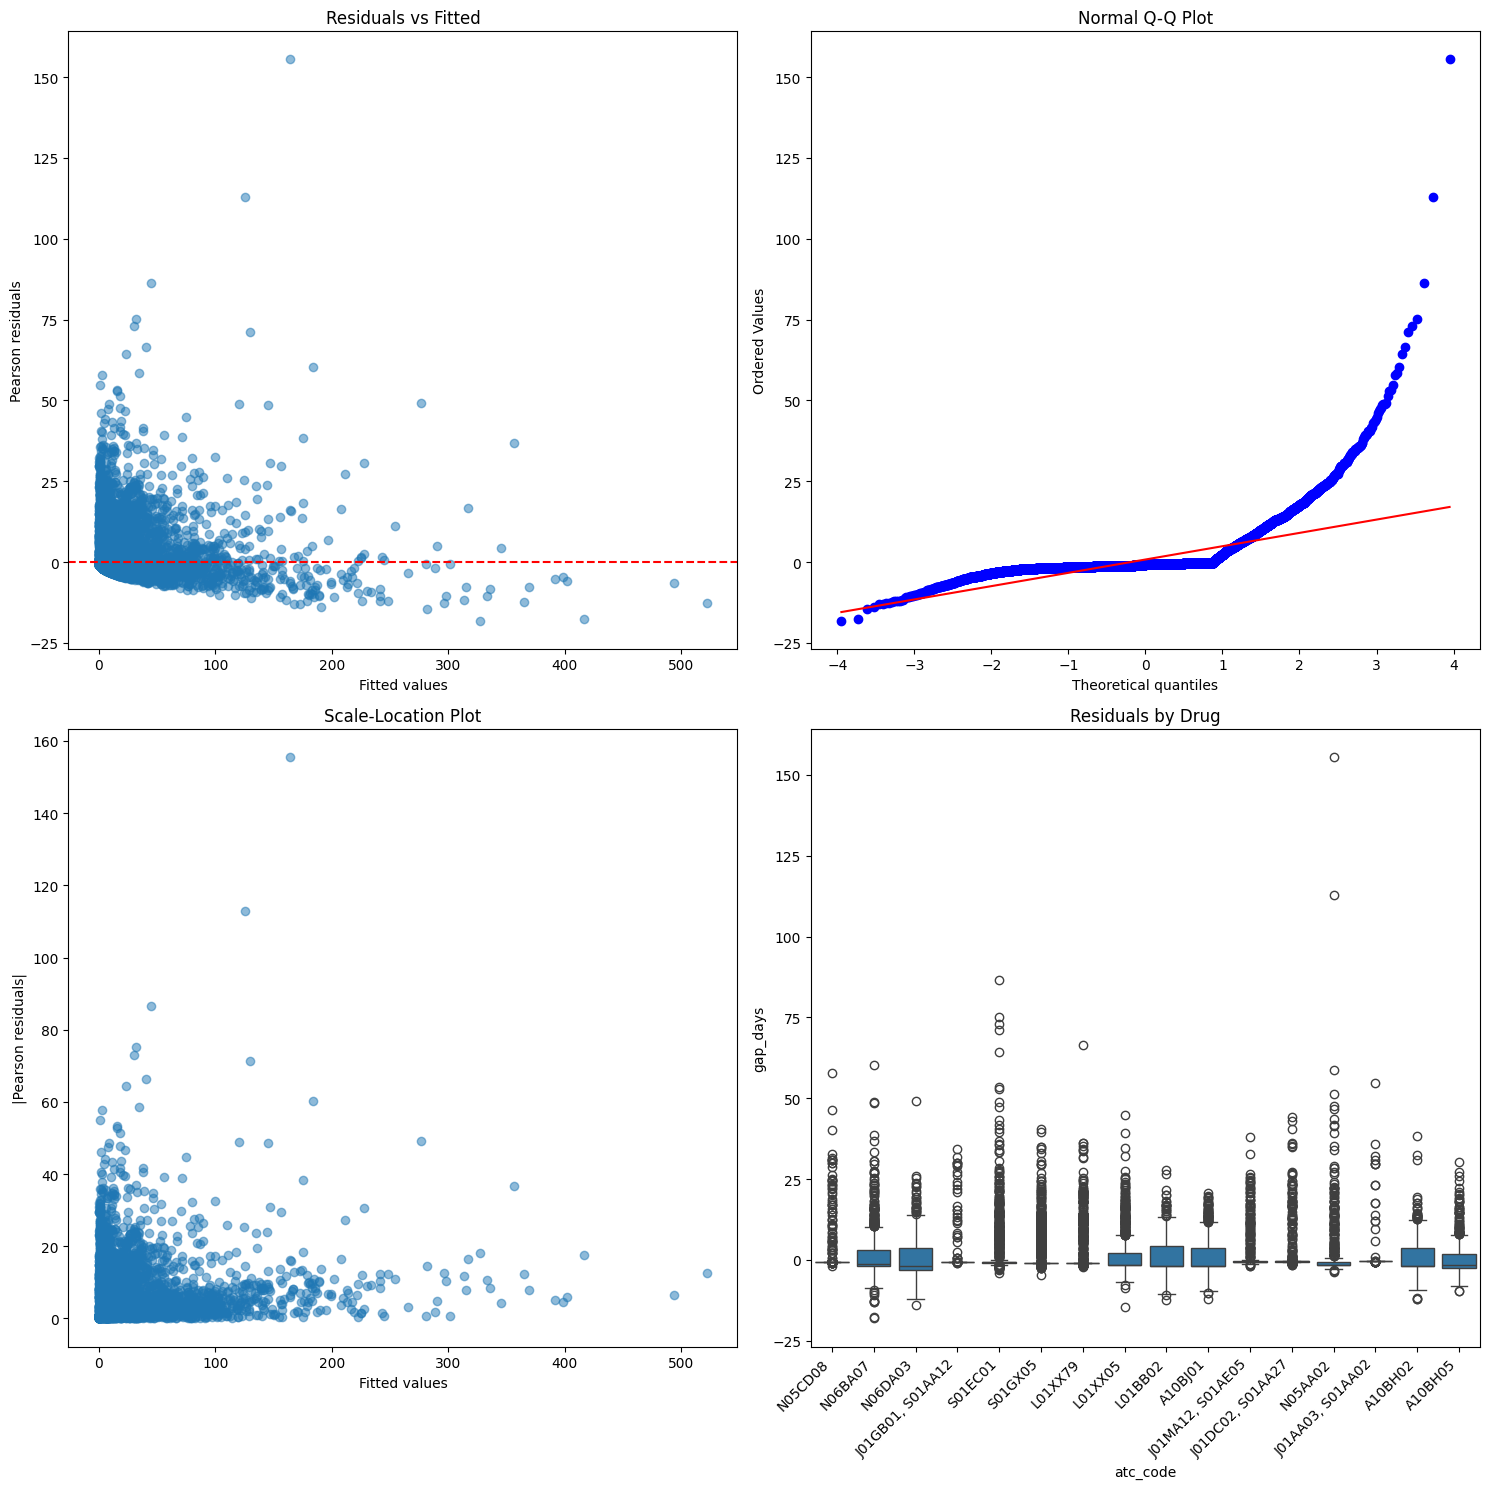


Residual Statistics:
Mean of residuals: 0.794
Std of residuals: 5.693
Skewness: 5.252
Kurtosis: 62.080


In [138]:
from scipy import stats

# Residual analysis

fitted_values = zinb_results.predict(which="mean")
observed = df["gap_days"]
pearson_residuals = (observed - fitted_values) / np.sqrt(fitted_values)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted_values, pearson_residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color="r", linestyle="--")
axes[0, 0].set_xlabel("Fitted values")
axes[0, 0].set_ylabel("Pearson residuals")
axes[0, 0].set_title("Residuals vs Fitted")

# 2. Q-Q plot

qq = stats.probplot(
    pearson_residuals[~np.isnan(pearson_residuals)], dist="norm", plot=axes[0, 1]
)
axes[0, 1].set_title("Normal Q-Q Plot")

# 3. Scale-Location plot
axes[1, 0].scatter(fitted_values, np.abs(pearson_residuals), alpha=0.5)
axes[1, 0].set_xlabel("Fitted values")
axes[1, 0].set_ylabel("|Pearson residuals|")
axes[1, 0].set_title("Scale-Location Plot")

# 4. Residuals vs Drug
sns.boxplot(x="atc_code", y=pearson_residuals, data=df, ax=axes[1, 1])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha="right")
axes[1, 1].set_title("Residuals by Drug")

plt.tight_layout()
plt.show()

print("\nResidual Statistics:")
print(f"Mean of residuals: {np.mean(pearson_residuals):.3f}")
print(f"Std of residuals: {np.std(pearson_residuals):.3f}")
print(f"Skewness: {stats.skew(pearson_residuals[~np.isnan(pearson_residuals)]):.3f}")
print(
    f"Kurtosis: {stats.kurtosis(pearson_residuals[~np.isnan(pearson_residuals)]):.3f}"
)

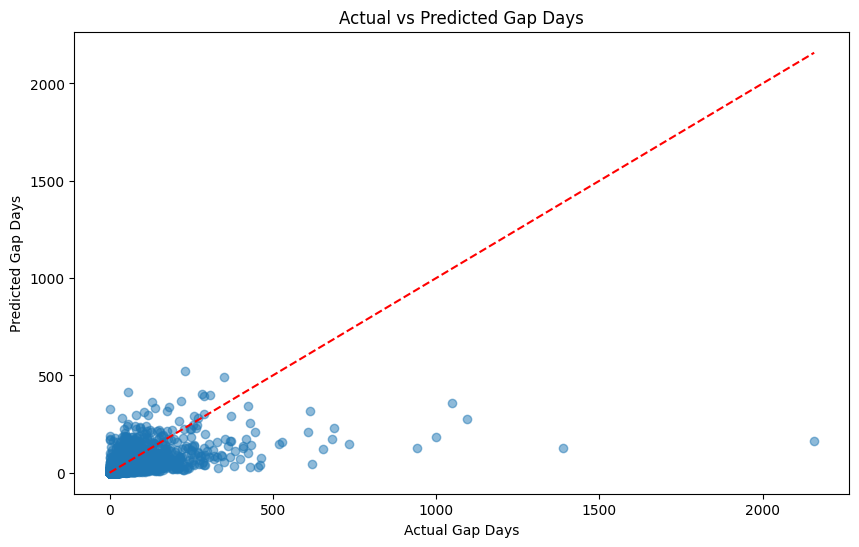

In [156]:
df_zinb = df.copy()
df_zinb["pred_count"] = zinb_results.predict()

plt.figure(figsize=(10, 6))
plt.scatter(df_zinb["gap_days"], df_zinb["pred_count"], alpha=0.5)
plt.plot([0, df_zinb["gap_days"].max()], [0, df_zinb["gap_days"].max()], "r--")
plt.xlabel("Actual Gap Days")
plt.ylabel("Predicted Gap Days")
plt.title("Actual vs Predicted Gap Days")
plt.show()

## two-stage approach

In [139]:
# Two-stage approach
# 1. Model zero vs non-zero with logistic regression
df_common = df.copy()
df_common["is_zero"] = (df_common["gap_days"] == 0).astype(int)
logit_model = sm.Logit.from_formula("is_zero ~ C(atc_code)", data=df_common)
logit_results = logit_model.fit()

# 2. Model non-zero values with truncated negative binomial
df_nonzero = df_common[df_common["gap_days"] > 0].copy()
nb_model_nonzero = sm.GLM.from_formula(
    "gap_days ~ C(atc_code)",
    data=df_nonzero,
    family=sm.families.NegativeBinomial(),
    offset=np.log(df_nonzero["duration"]),
)
nb_results_nonzero = nb_model_nonzero.fit()

Optimization terminated successfully.
         Current function value: 0.449916
         Iterations 7


/Users/punny/Repos/Project_PerMed/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [97]:
print(nb_results_nonzero.summary())
print(nb_results_nonzero.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               gap_days   No. Observations:                 4419
Model:                            GLM   Df Residuals:                     4403
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20205.
Date:                Mon, 25 Nov 2024   Deviance:                       2392.3
Time:                        16:14:42   Pearson chi2:                 1.75e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1109
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [100]:
print(logit_results.summary())
print(logit_results.aic)

                           Logit Regression Results                           
Dep. Variable:                is_zero   No. Observations:                17668
Model:                          Logit   Df Residuals:                    17652
Method:                           MLE   Df Model:                           15
Date:                Mon, 25 Nov 2024   Pseudo R-squ.:                  0.2001
Time:                        16:17:19   Log-Likelihood:                -7949.1
converged:                       True   LL-Null:                       -9937.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.3690      0.084     -4.414      0.000      -0.533      -0.205
C(atc_code)[T.A10BH05]             -0.5868      0.112     -5.257    

In [140]:
# For logistic part
print("Logistic Regression Metrics:")
print(f"Pseudo R-squared: {logit_results.prsquared:.3f}")
print(f"AIC: {logit_results.aic:.2f}")
print(f"Log-likelihood: {logit_results.llf:.2f}")

# For negative binomial part
print("\nNegative Binomial Metrics:")
print(f"AIC: {nb_results_nonzero.aic:.2f}")
print(f"Deviance: {nb_results_nonzero.deviance:.2f}")
print(
    f"Pearson Chi-squared/df: {nb_results_nonzero.pearson_chi2/nb_results_nonzero.df_resid:.2f}"
)

Logistic Regression Metrics:
Pseudo R-squared: 0.200
AIC: 15930.22
Log-likelihood: -7949.11

Negative Binomial Metrics:
AIC: 40441.82
Deviance: 2392.35
Pearson Chi-squared/df: 0.40


In [141]:
from sklearn.metrics import (
    classification_report,
    mean_squared_error,
    mean_absolute_error,
)


df_common["pred_prob_zero"] = logit_results.predict()
df_nonzero["pred_count"] = nb_results_nonzero.predict()

# Classification metrics for zero/non-zero prediction

print("\nZero/Non-zero Classification Report:")
print(classification_report(df_common["is_zero"], df_common["pred_prob_zero"] > 0.5))

# Count prediction metrics for non-zero values

print("\nCount Prediction Metrics (for non-zero values):")
print(
    f"RMSE: {np.sqrt(mean_squared_error(df_nonzero['gap_days'], df_nonzero['pred_count'])):.2f}"
)
print(
    f"MAE: {mean_absolute_error(df_nonzero['gap_days'], df_nonzero['pred_count']):.2f}"
)


Zero/Non-zero Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.46      0.53      4419
           1       0.83      0.91      0.87     13249

    accuracy                           0.79     17668
   macro avg       0.73      0.68      0.70     17668
weighted avg       0.78      0.79      0.78     17668


Count Prediction Metrics (for non-zero values):
RMSE: 72.70
MAE: 32.51


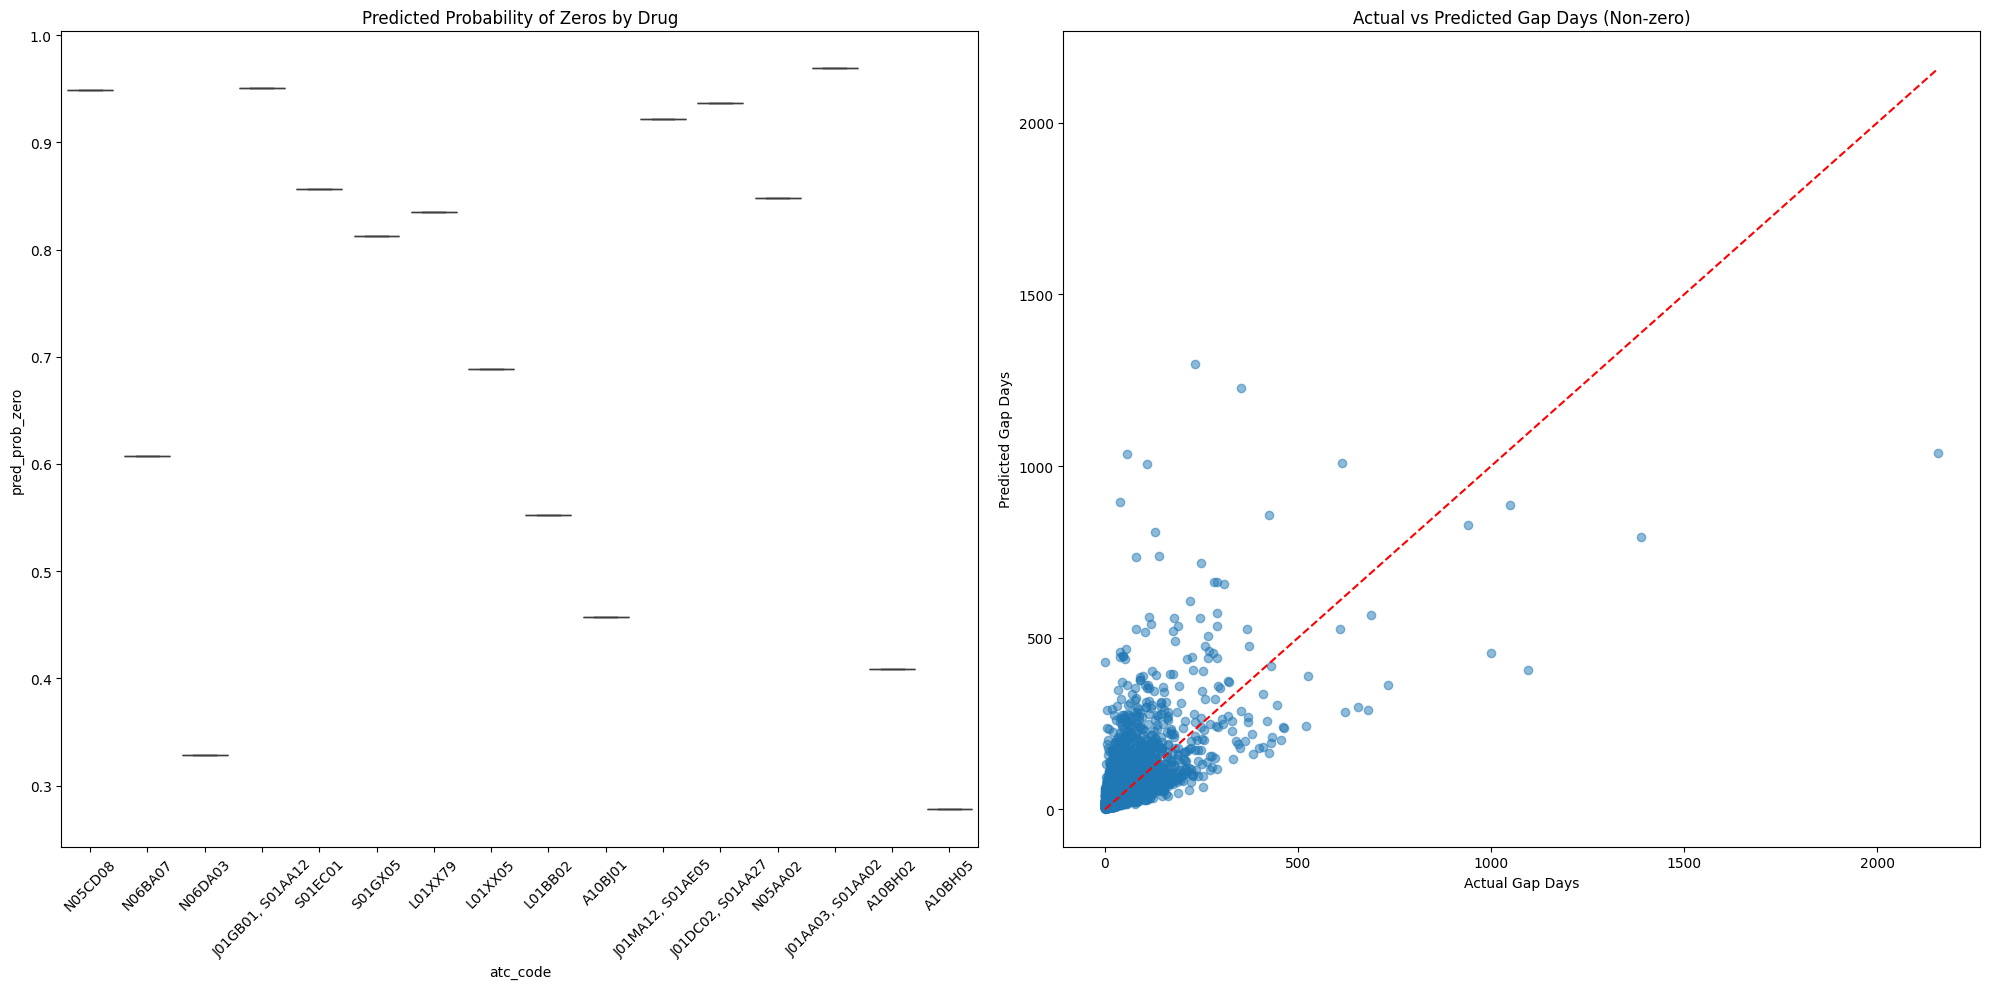

In [150]:
# actual vs predicted probabilities of zeros
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.boxplot(x="atc_code", y="pred_prob_zero", data=df_common)
plt.xticks(rotation=45)
plt.title("Predicted Probability of Zeros by Drug")

# actual vs predicted counts for non-zero values
plt.subplot(1, 2, 2)
plt.scatter(df_nonzero["gap_days"], df_nonzero["pred_count"], alpha=0.5)
plt.plot([0, df_nonzero["gap_days"].max()], [0, df_nonzero["gap_days"].max()], "r--")
plt.xlabel("Actual Gap Days")
plt.ylabel("Predicted Gap Days")
plt.title("Actual vs Predicted Gap Days (Non-zero)")

plt.tight_layout()
plt.show()